## Загрузка данных

In [ ]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from math import sqrt

# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


In [ ]:
df = pd.read_excel('train.xlsx', header=5)

In [ ]:
df

,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли.1","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки",...,Итого.11,"ТВ, trp\n(Ж 30-60 ВС).12","ТВ, охват 5+\n(Ж 30-60 ВС).12","ТВ, рубли.12","Диджитал, руб.12","ТВ спонсорство, рубли.12","OOH, рубли.12","Радио, рубли.13",Итого.12,Unnamed: 147
0,2019.0,1,2018-12-31,4.153557e+07,114621.15,0.0,0.0,0.0,0.0,0.0,...,1.183425e+07,207.903106,15.3615,9085528.010323,0.0,0.0,0.0,0.0,9.085528e+06,NaN
1,NaN,2,2019-01-07,5.122229e+07,141523.20,0.0,0.0,0.0,0.0,0.0,...,1.399653e+07,317.467542,25.5255,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
2,NaN,3,2019-01-14,5.712735e+07,157926.30,0.0,0.0,0.0,0.0,0.0,...,1.146629e+07,192.816682,13.9125,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
3,NaN,4,2019-01-21,6.304099e+07,173746.65,0.0,0.0,0.0,0.0,0.0,...,1.076463e+07,138.371621,8.0535,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
4,NaN,5,2019-01-28,6.733689e+07,185551.80,0.0,0.0,0.0,0.0,0.0,...,1.098497e+07,286.984113,24.2235,12893092.405548,0.0,0.0,0.0,0.0,1.289309e+07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,NaN,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,NaN,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,NaN,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,NaN,52,2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Анализ нашего поведения

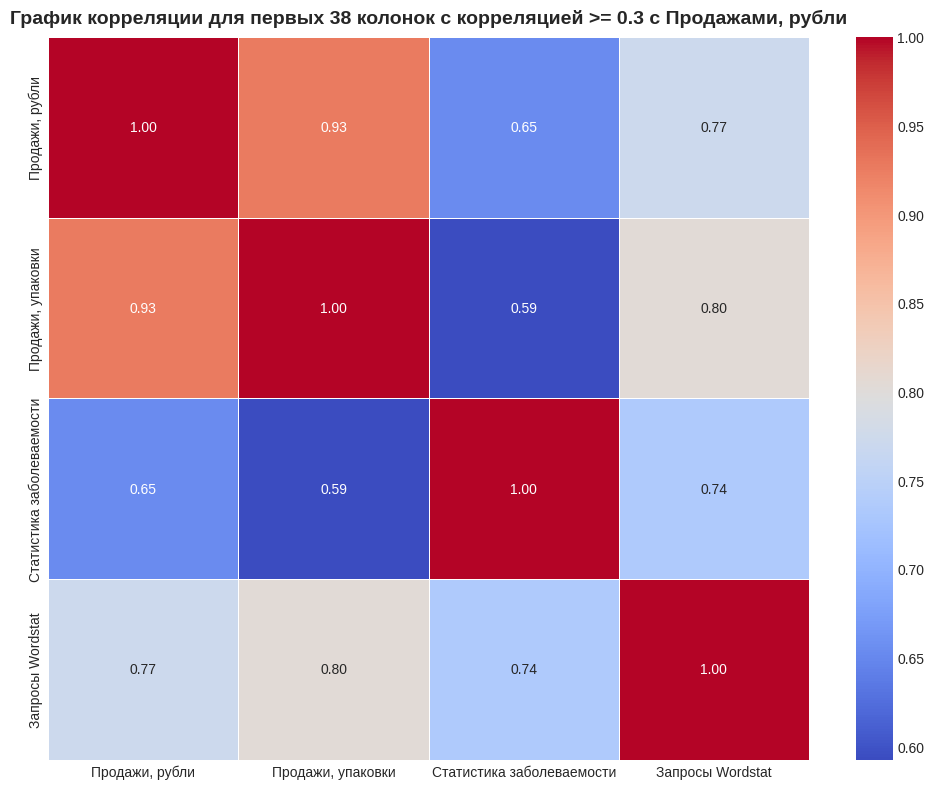

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

relevant_data = df.iloc[:, :38]
relevant_data = relevant_data.replace(r'[^\d.]', '', regex=True)
relevant_data = relevant_data.apply(pd.to_numeric)
relevant_data = relevant_data.fillna(relevant_data.mean())

correlation_matrix = relevant_data.corr()

relevant_columns = correlation_matrix[correlation_matrix['Продажи, рубли'] >= 0.3].index
relevant_data = relevant_data[relevant_columns]

correlation_matrix = relevant_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('График корреляции для первых 38 колонок с корреляцией >= 0.3 с Продажами, рубли')
plt.show()

#Анализируем поведение конкурентов 12


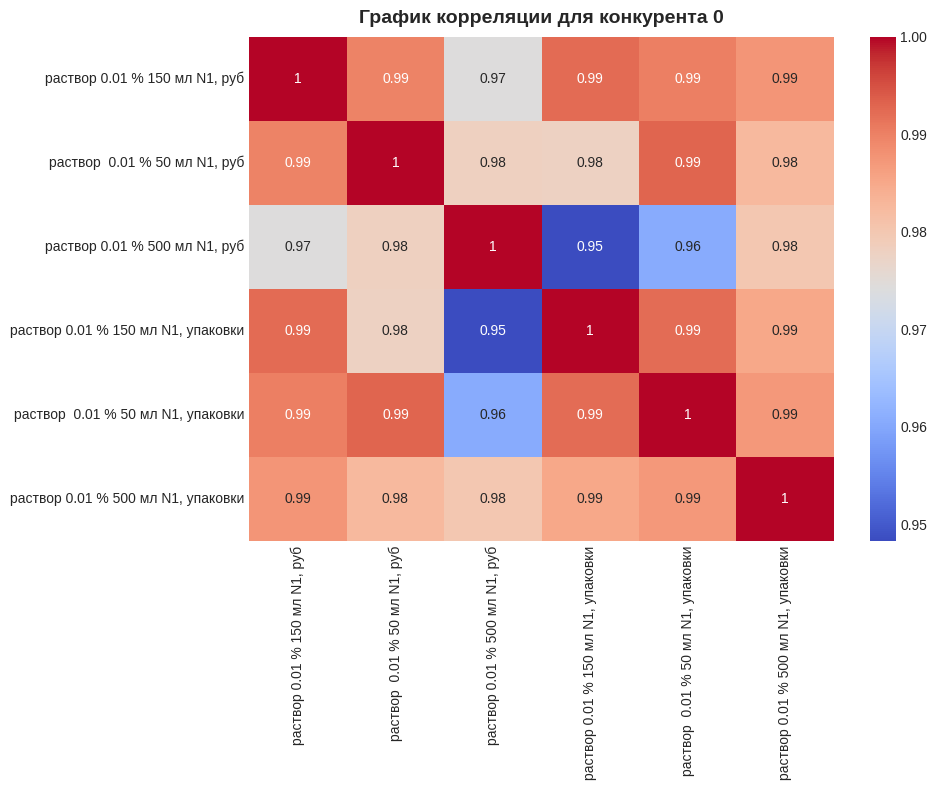

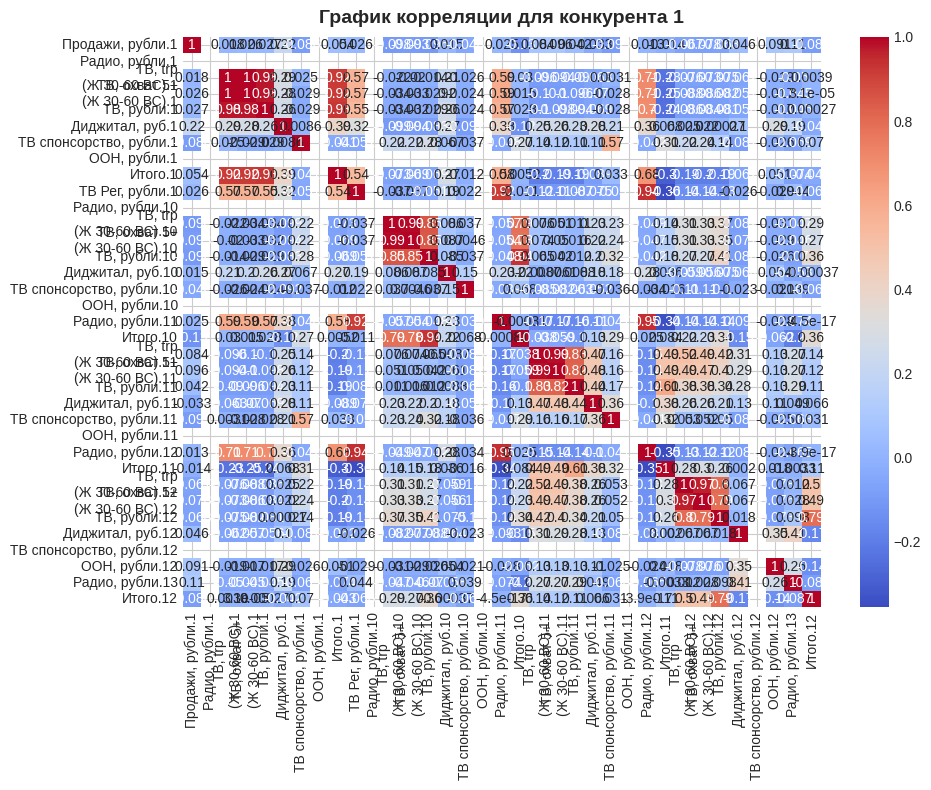

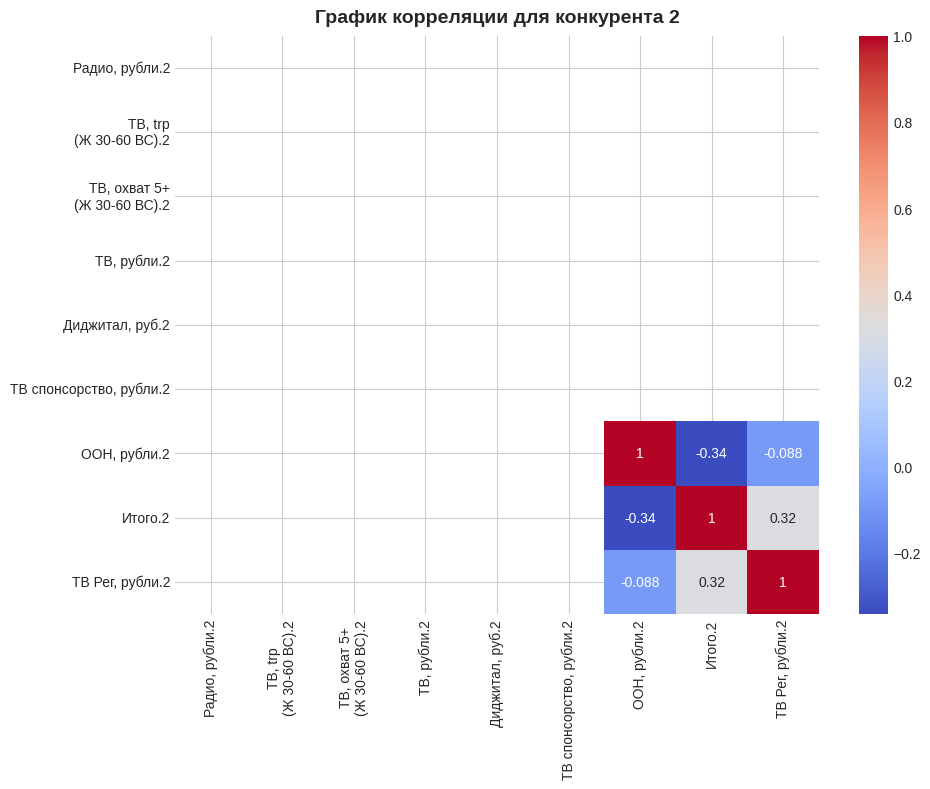

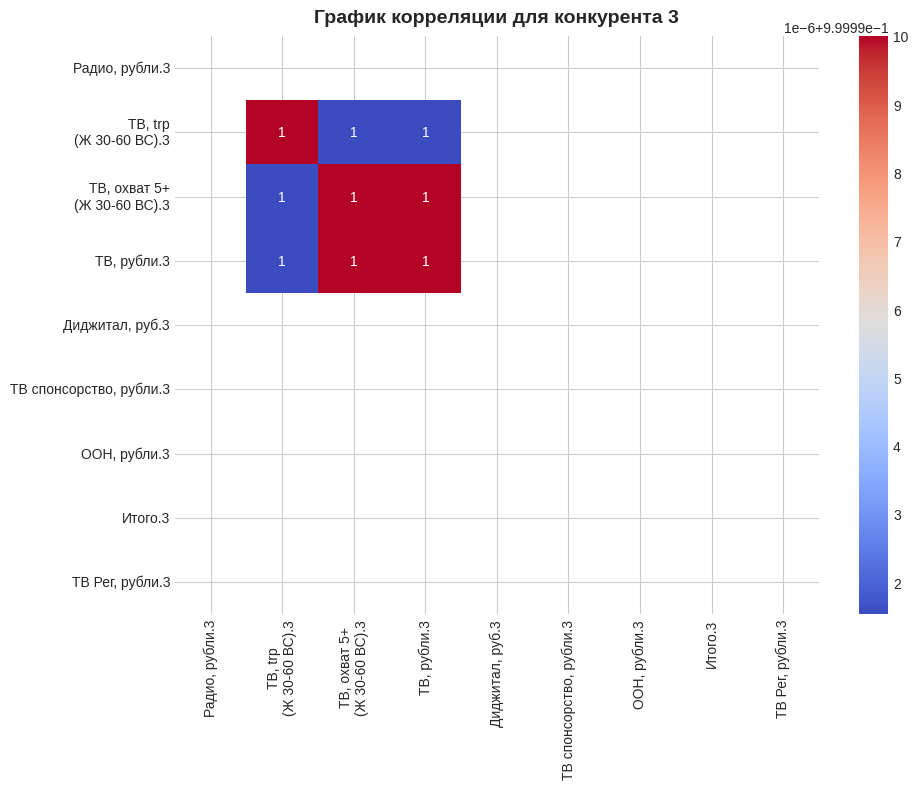

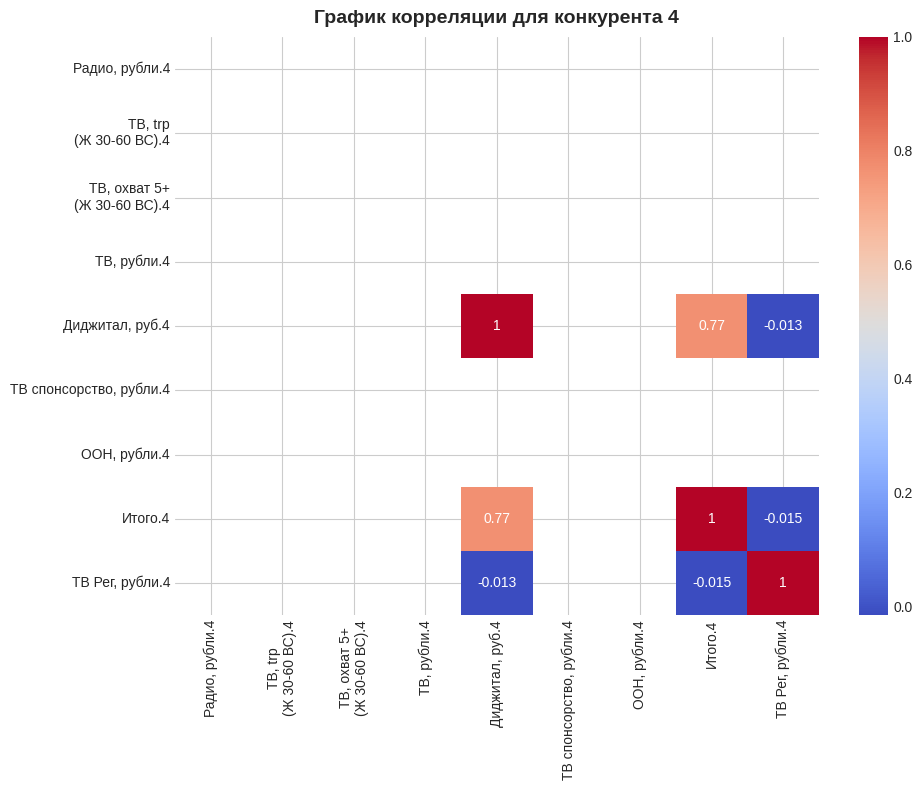

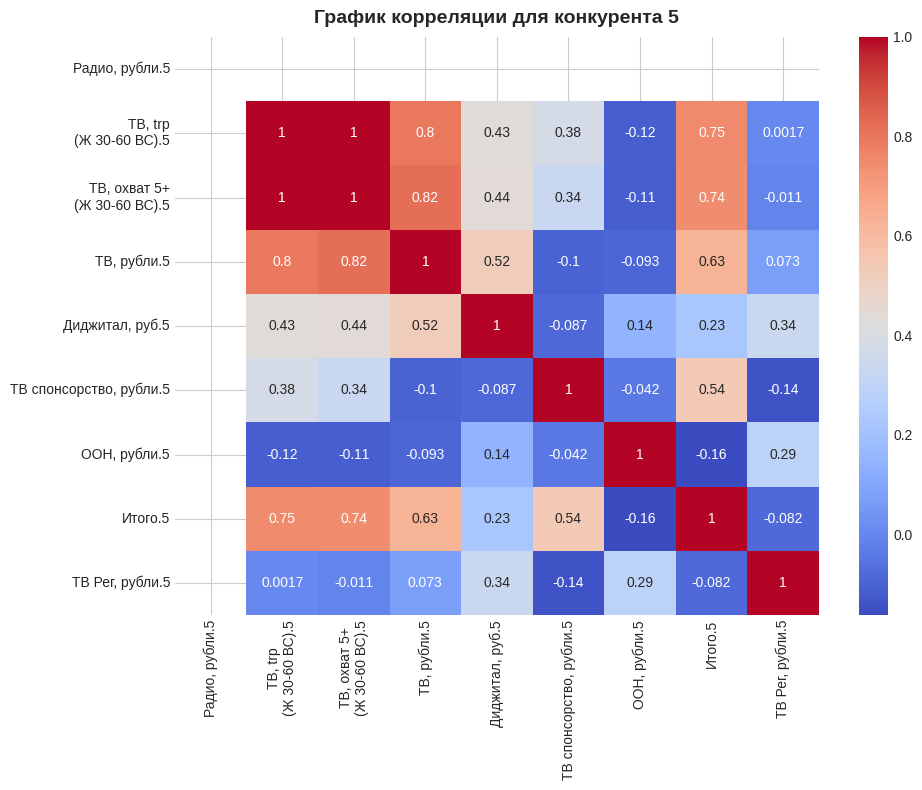

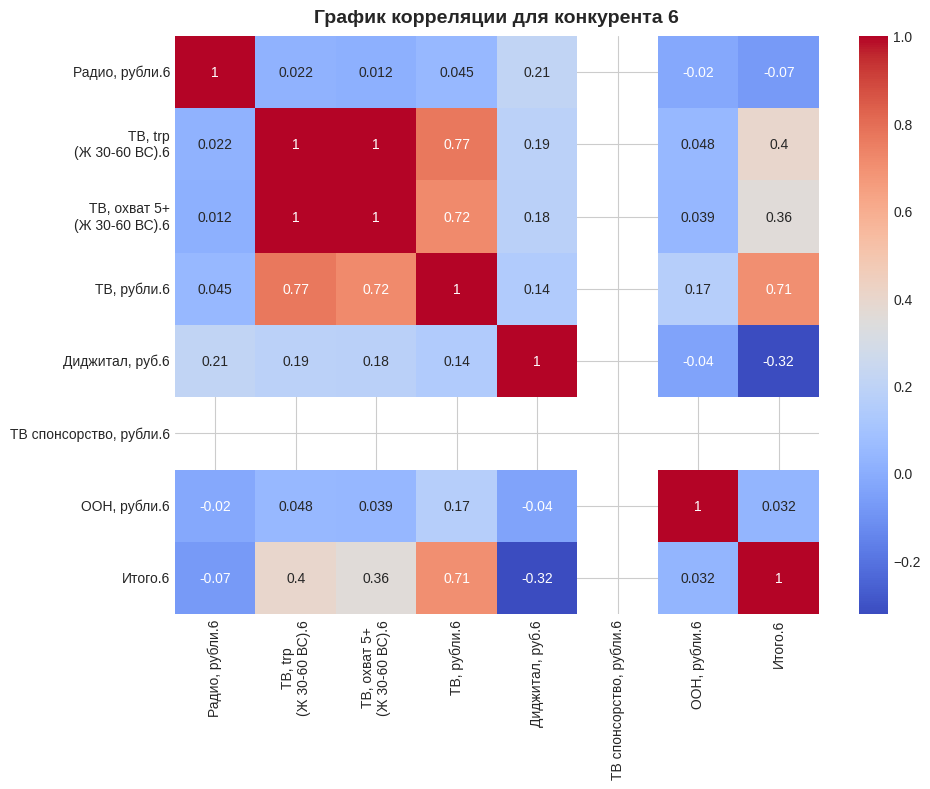

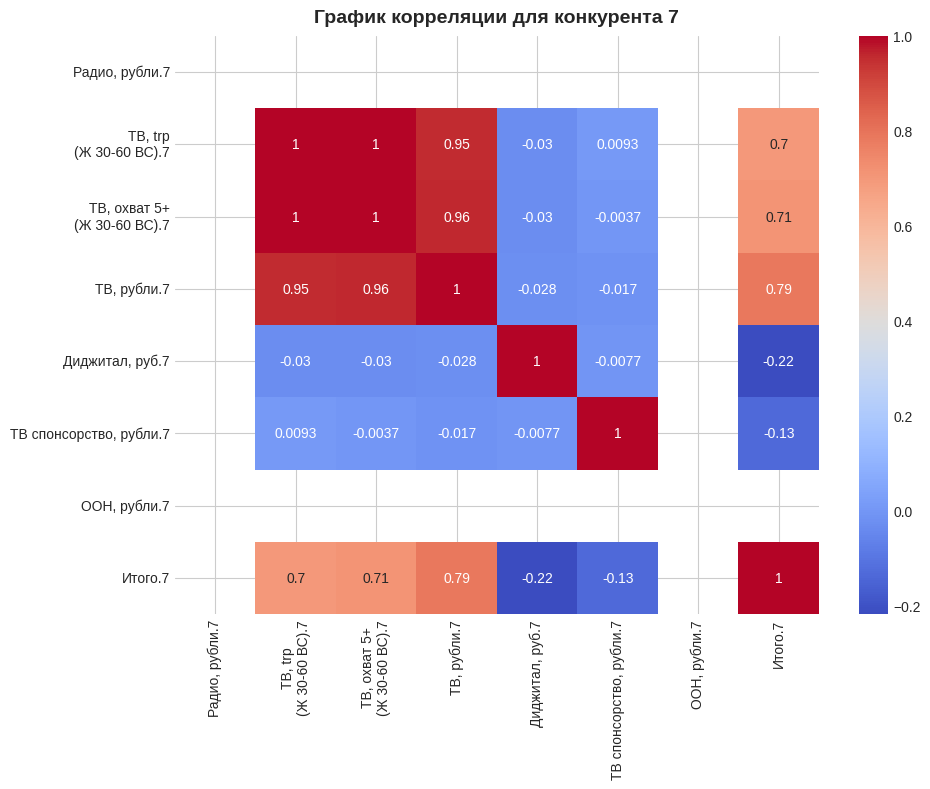

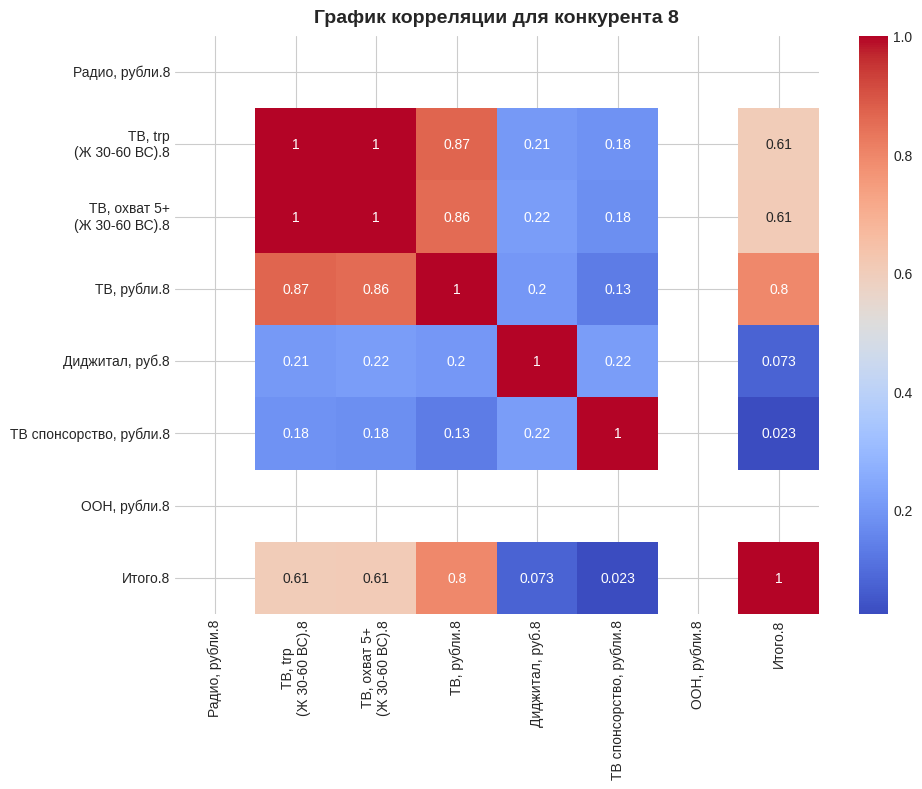

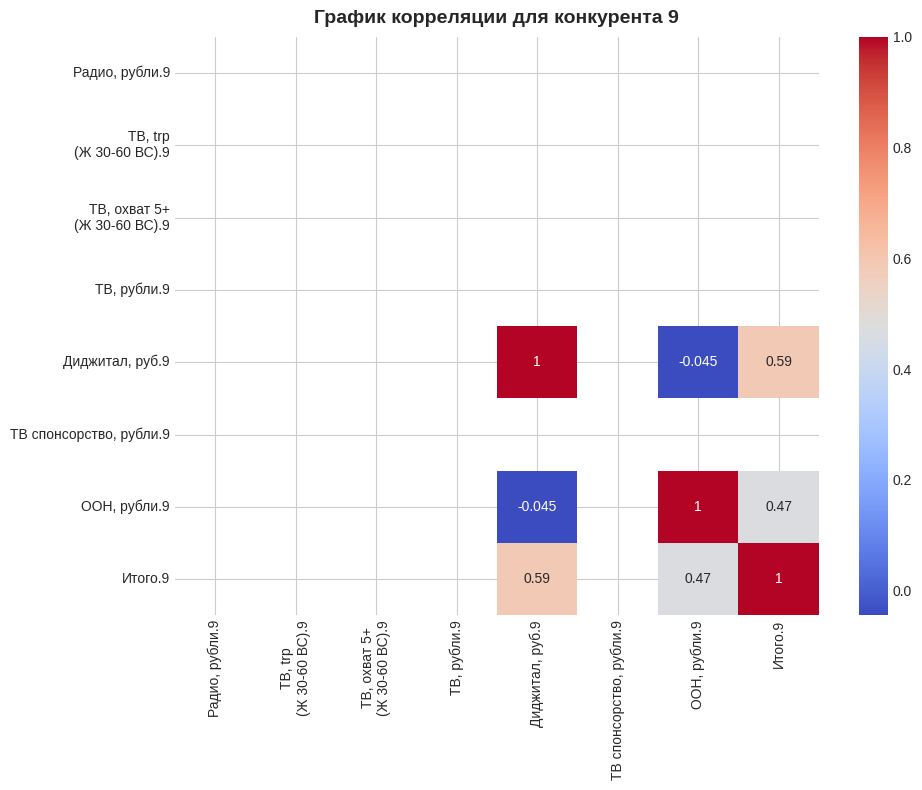

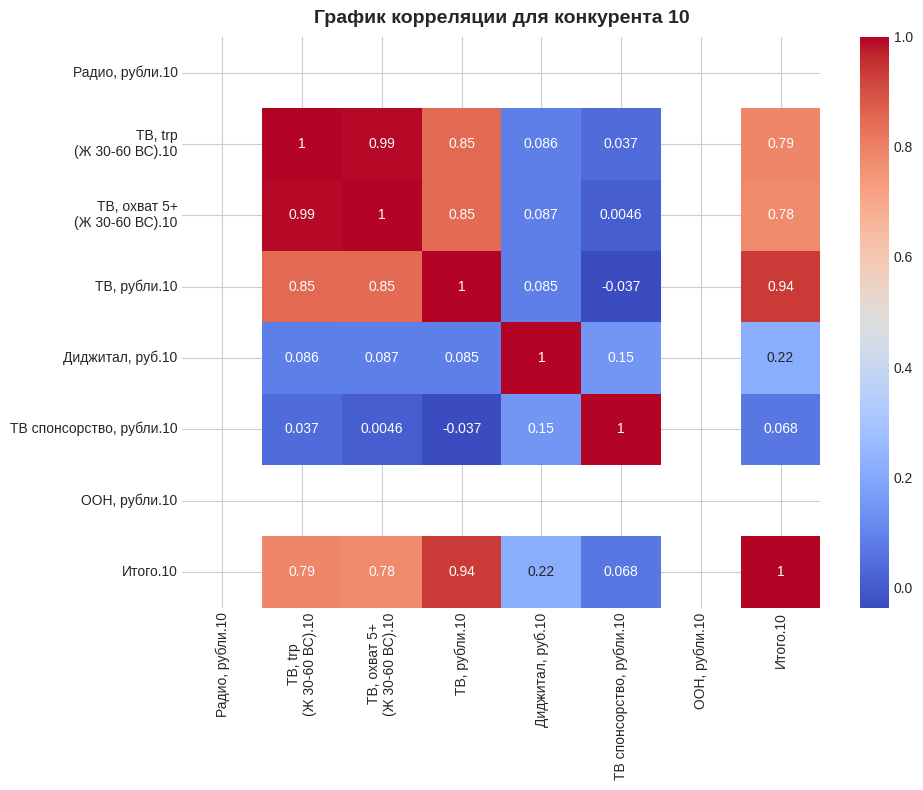

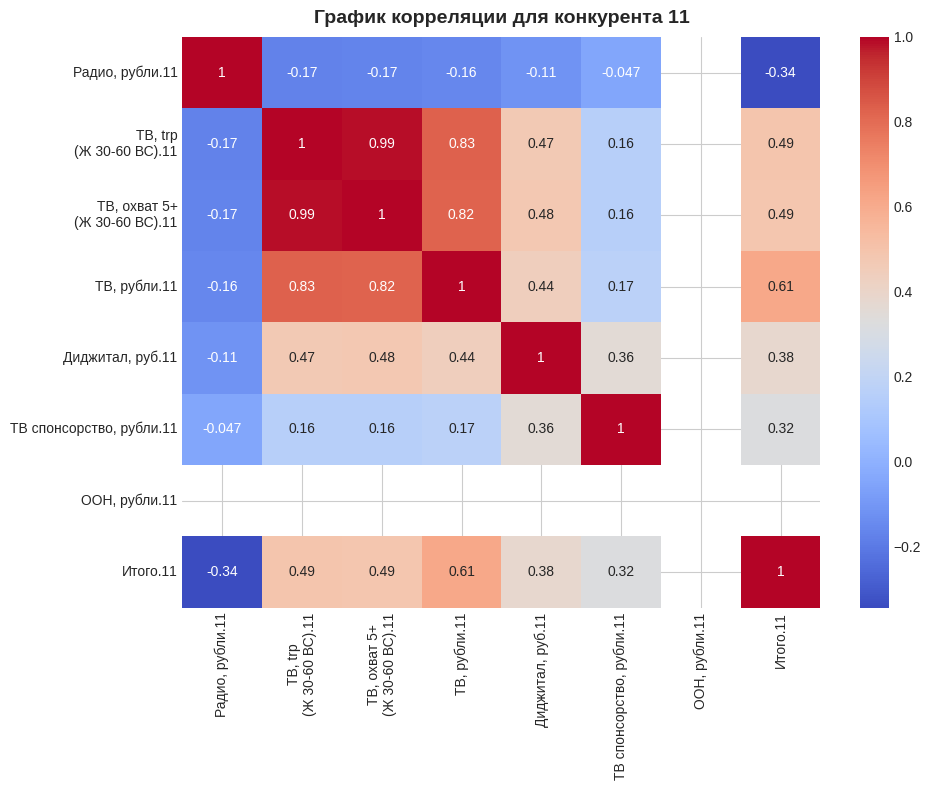

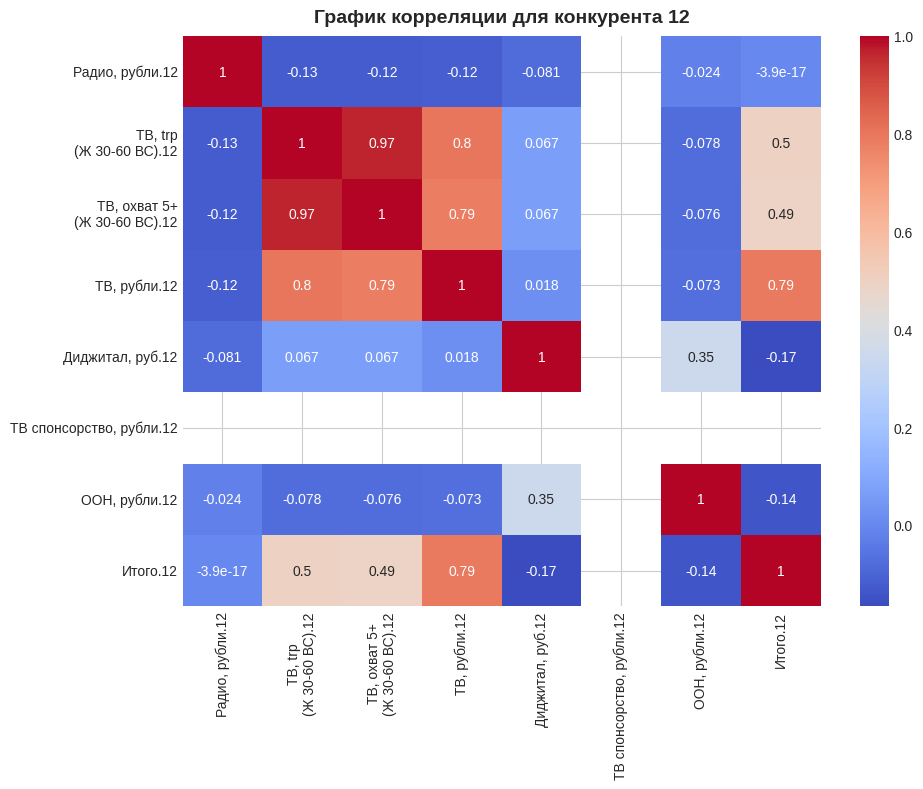

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

competitors = 12

for i in range(0, competitors + 1):
    relevant_columns = [col for col in df.columns if f'.{i}' in col]
    relevant_data = df[relevant_columns]
    relevant_data = relevant_data.replace(r'[^\d.]', '', regex=True)
    relevant_data = relevant_data.apply(pd.to_numeric)
    relevant_data = relevant_data.fillna(relevant_data.mean())

    correlation_matrix = relevant_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'График корреляции для конкурента {i}')
    plt.show()

#Само решение

In [ ]:
df.head()

,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли.1","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки",...,Итого.11,"ТВ, trp\n(Ж 30-60 ВС).12","ТВ, охват 5+\n(Ж 30-60 ВС).12","ТВ, рубли.12","Диджитал, руб.12","ТВ спонсорство, рубли.12","OOH, рубли.12","Радио, рубли.13",Итого.12,Unnamed: 147
0,2019.0,1,2018-12-31,4.153557e+07,114621.15,0.0,0.0,0.0,0.0,0.0,...,1.183425e+07,207.903106,15.3615,9085528.010323,0.0,0.0,0.0,0.0,9.085528e+06,NaN
1,NaN,2,2019-01-07,5.122229e+07,141523.20,0.0,0.0,0.0,0.0,0.0,...,1.399653e+07,317.467542,25.5255,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
2,NaN,3,2019-01-14,5.712735e+07,157926.30,0.0,0.0,0.0,0.0,0.0,...,1.146629e+07,192.816682,13.9125,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
3,NaN,4,2019-01-21,6.304099e+07,173746.65,0.0,0.0,0.0,0.0,0.0,...,1.076463e+07,138.371621,8.0535,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
4,NaN,5,2019-01-28,6.733689e+07,185551.80,0.0,0.0,0.0,0.0,0.0,...,1.098497e+07,286.984113,24.2235,12893092.405548,0.0,0.0,0.0,0.0,1.289309e+07,NaN


In [ ]:
df=df[['Начало нед','Продажи, рубли']]

In [ ]:
df = df.dropna()
df.tail()

,Начало нед,"Продажи, рубли"
239,2023-07-31,5.693151e+07
240,2023-08-07,5.988151e+07
241,2023-08-14,6.111218e+07
242,2023-08-21,6.159493e+07
243,2023-08-28,6.310668e+07


In [ ]:
df

,Начало нед,"Продажи, рубли"
0,2018-12-31,4.153557e+07
1,2019-01-07,5.122229e+07
2,2019-01-14,5.712735e+07
3,2019-01-21,6.304099e+07
4,2019-01-28,6.733689e+07
...,...,...
239,2023-07-31,5.693151e+07
240,2023-08-07,5.988151e+07
241,2023-08-14,6.111218e+07
242,2023-08-21,6.159493e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 0 to 243
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Начало нед      244 non-null    datetime64[ns]
 1   Продажи, рубли  244 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.7 KB


#Период на сколько предсказываем

In [ ]:
prediction_window=29

In [ ]:
n_input=29
n_features=1

In [ ]:
train = df.copy()

#EDA

In [ ]:
train.set_index("Начало нед", inplace=True)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train[['Продажи, рубли']].values)
scaled_train = scaler.transform(train[['Продажи, рубли']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [ ]:
x, y = sliding_windows(scaled_train, prediction_window)

In [ ]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.01070068 0.06240174 0.0939189  0.12548186 0.14841042 0.16488986
 0.15526511 0.11855399 0.11816041 0.081026   0.1112304  0.09703429
 0.08248266 0.0769983  0.07971271 0.08844733 0.07467878 0.05371951
 0.01583538 0.03125025 0.03339468 0.03522407 0.04186182 0.04296373
 0.03907252 0.0358574  0.03405011 0.03922388 0.03691539]
Predict this value: 
 [0.03210049]


In [ ]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

In [ ]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# LSTM Modeling

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )

        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()

    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc2(self.relu(self.fc1(h_out)))

        return out

Then we set some parameters for the training:

In [ ]:
EPOCHS = 500
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [ ]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# LSTM Training Loop

In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)

    train_loss = criterion(output, y_train)

    train_loss.backward()
    optimizer.step()


    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Epoch 0: Validation loss decreased (inf --> 0.013477).  Saving model ...
	 Train_Loss: 0.0171 Val_Loss: 0.0135  BEST VAL Loss: 0.0135

Epoch 1: Validation loss decreased (0.013477 --> 0.004964).  Saving model ...
	 Train_Loss: 0.0243 Val_Loss: 0.0050  BEST VAL Loss: 0.0050

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.0164 Val_Loss: 0.0056  BEST VAL Loss: 0.0050

Epoch 3: Validation loss did not decrease
	 Train_Loss: 0.0173 Val_Loss: 0.0058  BEST VAL Loss: 0.0050

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.0176 Val_Loss: 0.0050  BEST VAL Loss: 0.0050

Epoch 5: Validation loss decreased (0.004964 --> 0.004546).  Saving model ...
	 Train_Loss: 0.0166 Val_Loss: 0.0045  BEST VAL Loss: 0.0045

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.0159 Val_Loss: 0.0047  BEST VAL Loss: 0.0045

Epoch 7: Validation loss did not decrease
	 Train_Loss: 0.0159 Val_Loss: 0.0050  BEST VAL Loss: 0.0045

Epoch 8: Validation loss did not decrease
	 Train_Loss: 0.0160 Va

# LSTM Prediction

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [ ]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [ ]:
df_pred=train.iloc[-58:]
df_pred['prediction']=y_pred

<ipython-input-76-4b336dc6ab6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['prediction']=y_pred


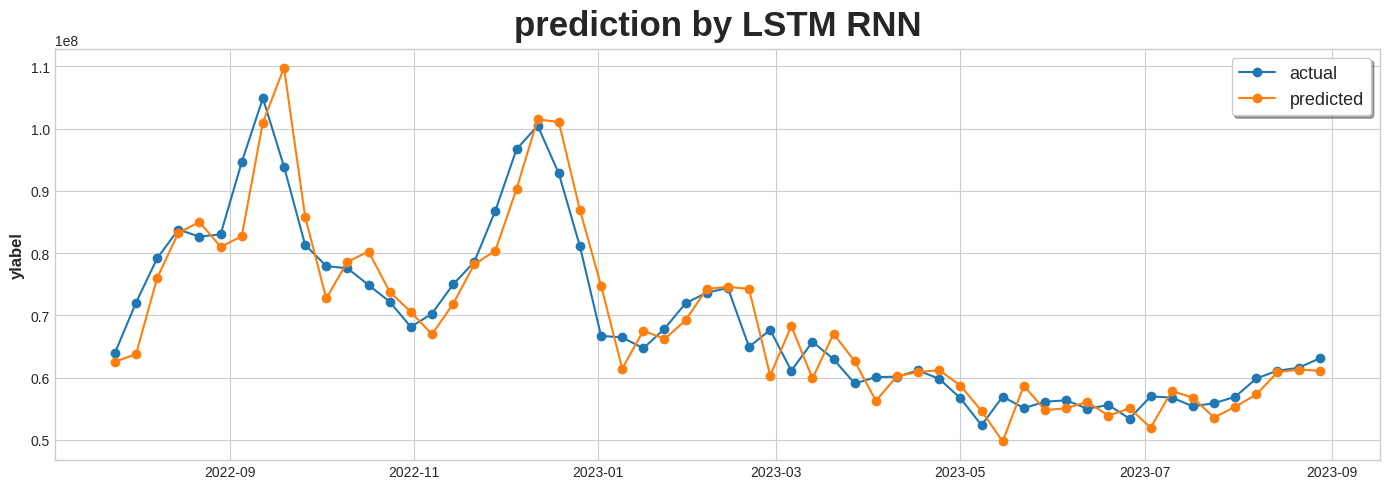

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["Продажи, рубли"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.title("prediction by LSTM RNN", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [ ]:
mape_lstm = mape(df_pred["Продажи, рубли"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 5.02 %


In [ ]:
rmse_lstm = mean_squared_error(df_pred["Продажи, рубли"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 4744321.16


# LSTM Forecasting

In [ ]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:])) # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(scaled_train[-n_input:])):
    #get the prediction value for the first batch
    current_pred = model(current_batch)
    #append the prediction into the array
    test_predictions.append(current_pred)

    #use the prediction to update the batch and remove the first value
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [ ]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)

#Предсказание для теста

In [ ]:
forecast_dates=pd.read_csv('sample_submission.csv')

In [ ]:
forecast_dates['week']

0     04.09.2023
1     11.09.2023
2     18.09.2023
3     25.09.2023
4     02.10.2023
5     09.10.2023
6     16.10.2023
7     23.10.2023
8     30.10.2023
9     06.11.2023
10    13.11.2023
11    20.11.2023
12    27.11.2023
13    04.12.2023
14    11.12.2023
15    18.12.2023
16    25.12.2023
17    01.01.2024
18    08.01.2024
19    15.01.2024
20    22.01.2024
21    29.01.2024
22    05.02.2024
23    12.02.2024
24    19.02.2024
25    26.02.2024
26    04.03.2024
27    11.03.2024
28    18.03.2024
Name: week, dtype: object

In [ ]:
forecast_dates= forecast_dates.dropna()
forecast_dates.tail()
forecast_dates.set_index('week', inplace=True)

In [ ]:
df_forecast=forecast_dates
df_forecast['revenue'] = forec_vals
df_forecast.head(12)

,revenue
week,
04.09.2023,6.343247e+07
11.09.2023,6.351373e+07
18.09.2023,6.314607e+07
25.09.2023,6.271450e+07
02.10.2023,6.235240e+07
09.10.2023,6.204288e+07
16.10.2023,6.174622e+07
23.10.2023,6.143705e+07
30.10.2023,6.110361e+07


<Axes: xlabel='week'>

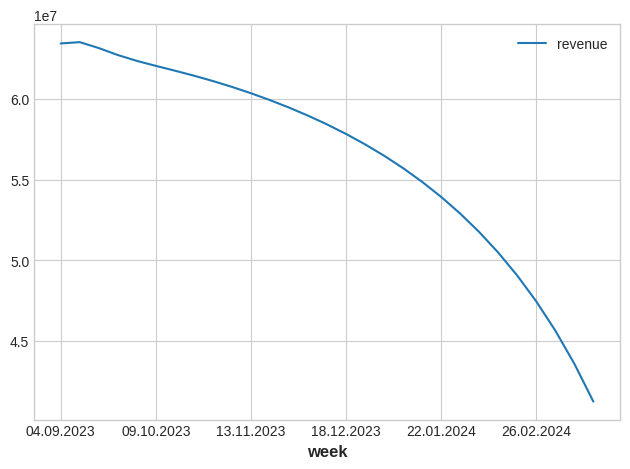

In [ ]:
df_forecast.plot()

In [ ]:
df_forecast

,revenue
week,
04.09.2023,6.343247e+07
11.09.2023,6.351373e+07
18.09.2023,6.314607e+07
25.09.2023,6.271450e+07
02.10.2023,6.235240e+07
09.10.2023,6.204288e+07
16.10.2023,6.174622e+07
23.10.2023,6.143705e+07
30.10.2023,6.110361e+07


In [ ]:
df_forecast.to_csv('subm_LSTM_Cat.csv')